<a href="https://colab.research.google.com/github/AlecTraas/computational-geo-lab/blob/main/Colab/Kai/quickhull_algo_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

In [19]:
def main(num_points):
  points = sorted([[rnd.random()*10, rnd.random()*10, rnd.random()*10] for _ in range(num_points)], key=lambda x: x[0])
  np_points = np.array(points)
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(np_points[:,0], np_points[:,1], np_points[:,2])
  hull = ConvexHull(points)
  hull.quick_hull()

In [ ]:
# I miss structs :(
class ConvexHull():
  def __init__(self, points):
    self.points = points
    self.hull_points = None
    self.hull_facets = None
    self.hull_ridges = None
    self.neighbors = None

  def quick_hull(self):
    define_tetrahedron()
    define_neighbors()
    clear_points_within_hull()

  def define_tetrahedron(self):
    """

    """

[[0.2307289  5.56626729 5.66083605]
 [0.44092979 4.38677822 3.85286037]
 [0.52148692 6.5113362  1.70740979]
 [0.64218041 3.84519663 1.77346914]
 [0.7526824  1.83054321 7.54245069]
 [0.84731211 9.59488318 7.73918764]
 [1.67870474 3.46682754 7.8098465 ]
 [1.78750545 7.55373465 8.92910426]
 [1.86108125 8.60349197 2.94780137]
 [1.91935876 1.58400633 3.09208296]
 [1.95525353 1.32828573 9.64975031]
 [2.08605204 5.14542527 1.34463105]
 [2.18069912 1.77819811 6.04471544]
 [2.33972415 5.68219896 9.28208682]
 [2.56939268 8.91007903 1.15203594]
 [2.92350181 9.88627774 7.24161513]
 [3.37712799 2.39598454 5.20095069]
 [3.37883294 1.19749219 2.03410511]
 [3.53495321 1.74803676 4.86108679]
 [3.5488938  8.90820251 4.93132633]
 [3.98553322 3.50404786 9.96225422]
 [4.15800587 0.74088402 2.26095219]
 [4.58315834 1.29756763 7.95445896]
 [4.6254842  8.08051082 7.73705486]
 [4.71530462 0.31360425 0.96522338]
 [5.22229172 3.93105856 3.10919941]
 [5.63752689 7.5546234  4.6368404 ]
 [6.13927973 8.52326703 4.62

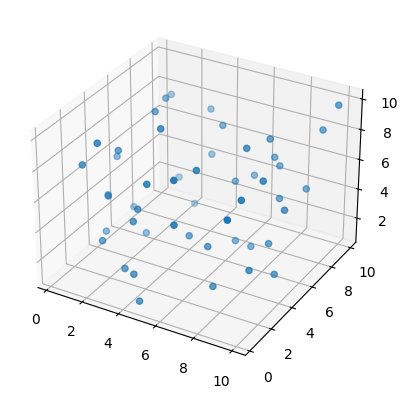

In [18]:
main(50)